In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

warnings.filterwarnings('ignore')

2025-05-11 20:23:47.629227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746995027.826447      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746995027.883514      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
image_path = '//kaggle/input/flickr30k/flickr30k_images'

In [3]:
data = pd.read_csv("/kaggle/input/flickr30k/captions.txt")
data.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,Two young White males are outside near many b...
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [4]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(6):
        n+=1
        plt.subplot(2 , 3, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/kaggle/input/flickr30k/flickr30k_images/{temp_df.image_name[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.comment[i], 20)))
        plt.axis("off")

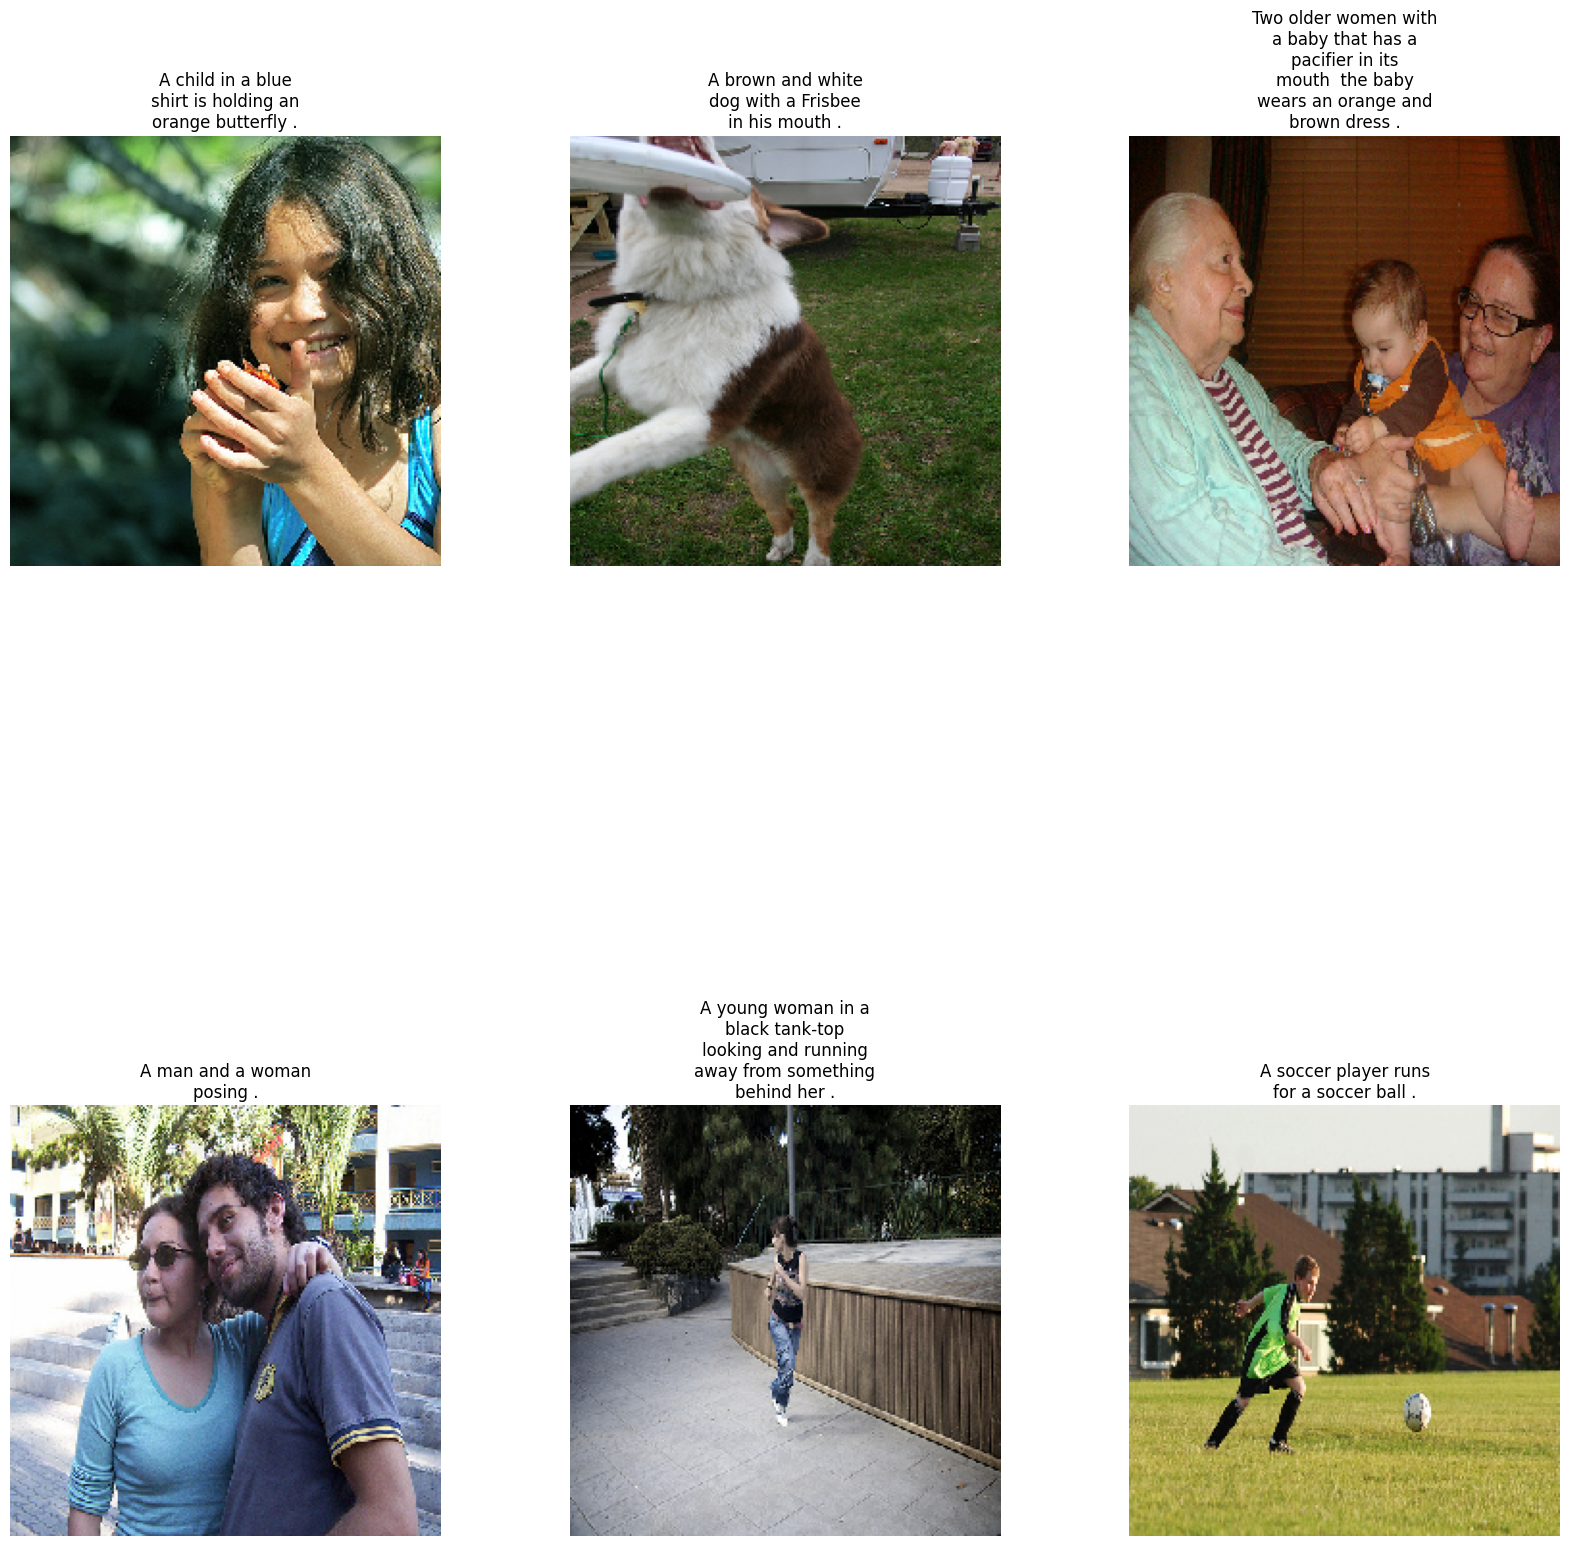

In [5]:
display_images(data.sample(6))

In [6]:
def text_preprocessing(data):
    data['comment'] = data['comment'].apply(lambda x: x.lower())
    data['comment'] = data['comment'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['comment'] = data['comment'].apply(lambda x: x.replace("\s+"," "))
    data['comment'] = data['comment'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['comment'] = "<start> "+data['comment']+" <end>"
    return data

In [7]:
data = text_preprocessing(data)
captions = data['comment'].tolist()
captions[:10]

['<start> two young guys with shaggy hair look at their hands while hanging out in the yard <end>',
 '<start> two young white males are outside near many bushes <end>',
 '<start> two men in green shirts are standing in yard <end>',
 '<start> man in blue shirt standing in garden <end>',
 '<start> two friends enjoy time spent together <end>',
 '<start> several men in hard hats are operating giant pulley system <end>',
 '<start> workers look down from up above on piece of equipment <end>',
 '<start> two men working on machine wearing hard hats <end>',
 '<start> four men on top of tall structure <end>',
 '<start> three men on large rig <end>']

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image_name'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image_name'].isin(train_images)]
test = data[data['image_name'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[2, 12, 21, 20, 708, 13, 54, 79, 194, 1420, 1]

In [9]:
df_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
sample = df_shuffled.iloc[:25000]
test = df_shuffled.iloc[25000:]

In [10]:
model = ResNet50()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(sample['image_name'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature 

I0000 00:00:1746995045.694957      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746995045.695628      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


  0%|          | 0/18301 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1746995051.711254      66 service.cc:148] XLA service 0x7b4534002c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746995051.711797      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746995051.711820      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746995052.318357      66 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746995054.781006      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 18301/18301 [23:26<00:00, 13.01it/s]


In [11]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


train_generator = CustomDataGenerator(df=sample,X_col='image_name',y_col='comment',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=sample,X_col='image_name',y_col='comment',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [12]:
import nltk
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.callbacks import Callback

class BLEUCallback(Callback):
    def __init__(self, val_data, tokenizer, max_length):
        super(BLEUCallback, self).__init__()
        self.val_data = validation_generator
        self.tokenizer = tokenizer
        self.max_length = max_length

    def generate_caption(self, image_feature):
        in_text = '<start>'
        for _ in range(self.max_length):
            sequence = self.tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=self.max_length)
            yhat = self.model.predict([image_feature, sequence], verbose=0)
            yhat = np.argmax(yhat)
            word = self.tokenizer.index_word.get(yhat)
            if word is None or word == '<end>':
                break
            in_text += ' ' + word
        return in_text.split()

    def on_epoch_end(self, epoch, logs=None):
        references = []
        hypotheses = []
        for (img_input, text_input), target_output in self.val_data:
            for i in range(len(img_input)):
                img_feat = img_input[i].reshape((1, img_input[i].shape[0]))
                y_true = target_output[i]  # one-hot
                ref_seq = np.argmax(y_true)
                ref_words = self.tokenizer.sequences_to_texts([[ref_seq]])[0].split()
                references.append([ref_words])

                y_pred_words = self.generate_caption(img_feat)
                hypotheses.append(y_pred_words)
        
        bleu4 = corpus_bleu(references, hypotheses)
        print(f"\nEpoch {epoch + 1} BLEU-4: {bleu4:.4f}")

In [13]:
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(2048,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')


from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint
model_name = "model.keras"  # Update the extension to .keras
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

history = caption_model.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 6.4447
Epoch 1: val_loss improved from inf to 5.11050, saving model to model.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 167s 413ms/step - loss: 6.4432 - val_loss: 5.1105 - learning_rate: 0.0010
Epoch 2/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 5.2061
Epoch 2: val_loss improved from 5.11050 to 4.77796, saving model to model.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 162s 411ms/step - loss: 5.2059 - val_loss: 4.7780 - learning_rate: 0.0010
Epoch 3/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 4.9219
Epoch 3: val_loss improved from 4.77796 to 4.57178, saving model to model.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 161s 409ms/step - loss: 4.9218 - val_loss: 4.5718 - learning_rate: 0.0010
Epoch 4/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 4.7609
Epoch 4: val_loss improved from 4.57178 to 4.43489, saving model to model.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 161s 408ms/step - loss: 4.7609 - val_loss: 4.4349 - learning_rate:

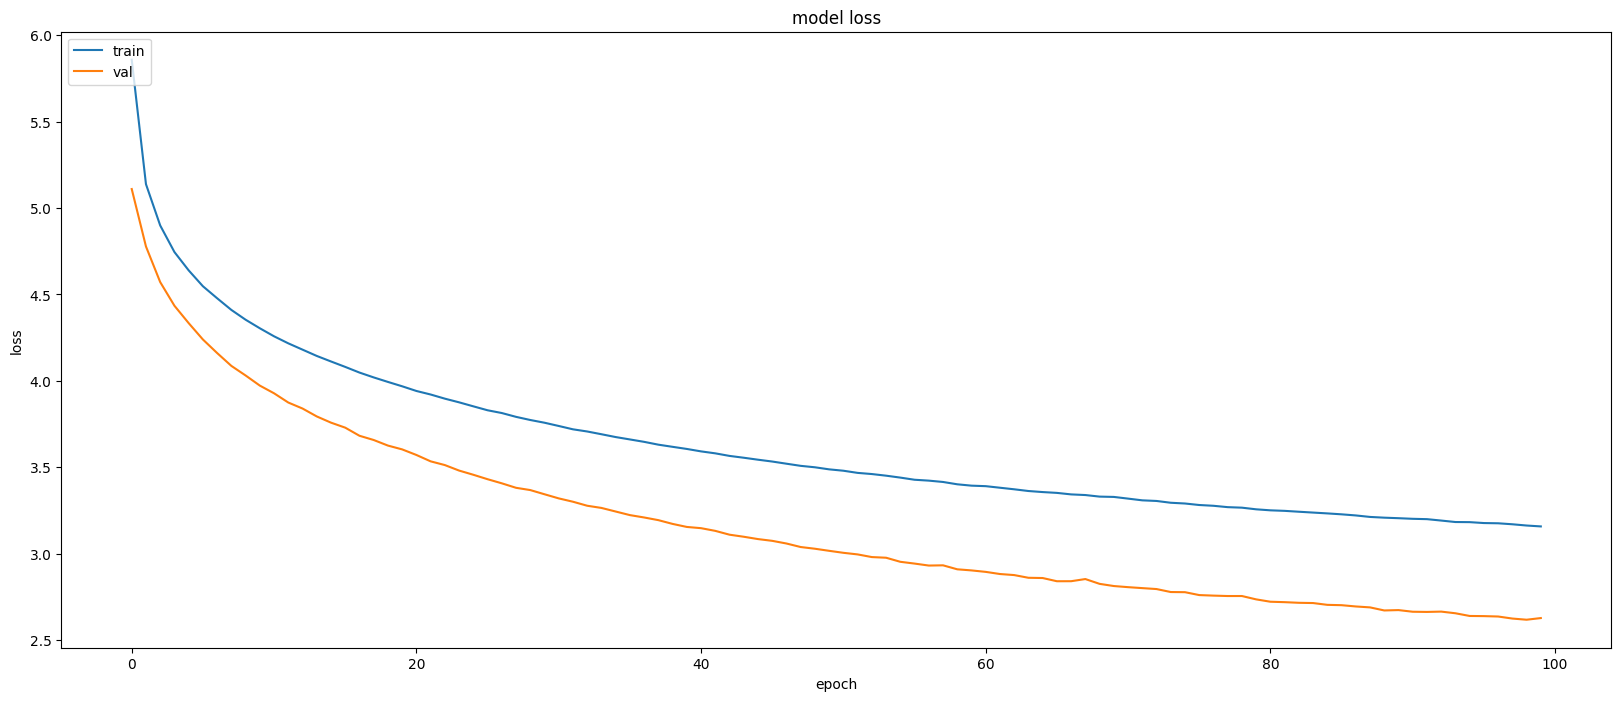

In [14]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
fe.save("feature_extractor.keras")

In [16]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=74, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features
    
    # Generate the caption
    in_text = "<start>"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "<end>":
            break
    caption = in_text.replace("<start>", "").replace("<end>", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

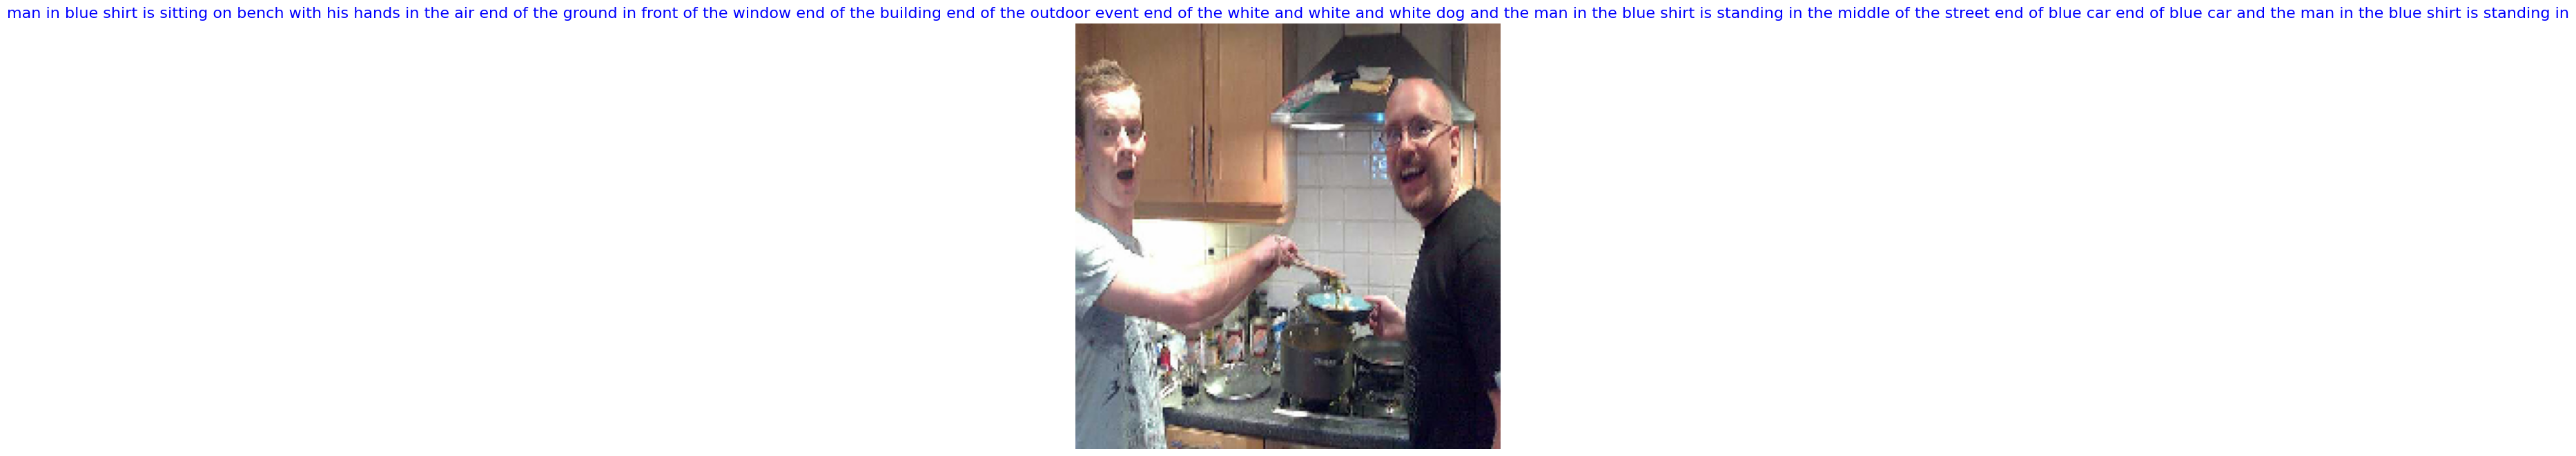

In [17]:
# Example usage
image_path = "/kaggle/input/flickr30k/flickr30k_images/1000366164.jpg"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

In [18]:
# image_path = "/kaggle/input/flickr8k/Images/1089181217_ee1167f7af.jpg"  # Replace with the path to the input image
# generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

In [19]:
# image_path = "/kaggle/input/flickr8k/Images/116409198_0fe0c94f3b.jpg"  # Replace with the path to the input image
# generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)